In [1]:
import pandas as pd
import numpy as np
import scipy.stats as si
import sympy as sy
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
pd.options.display.max_columns = None

In [2]:
#import dataset
df0 = pd.read_csv('loan.csv',low_memory=False)
#remove columns that won't be used
df0 = df0.drop(['url','id','member_id','funded_amnt_inv','loan_amnt','emp_title','desc','title'],axis=1)

In [3]:
#if NaN is > 50% then drop column
df1 = df0.dropna(axis=1,thresh=.5*len(df0))
#orignial df has 71 columns
len(df0.columns.tolist())
#dropped 21 columns that contained 50% or more NaN. now df has 50 
len(df1.columns.tolist())
#replace NaN with median for all integer columns
#create list of all int columns to use to replace NaN
is_numeric = np.vectorize(lambda x: np.issubdtype(x, np.number))
NaN_col = list(df1.columns[is_numeric(df1.dtypes)])
#fill in median value for all NaN's in numeric columns
pd.options.mode.chained_assignment = None 
df_numerics = pd.DataFrame(df1.loc[:,NaN_col].fillna(df1.median()))
df1.loc[:,NaN_col] = df_numerics
df = df1

In [4]:
#strip out number of months from term
def strip_int(string):
    """removes numbers from string with numbers and letters. converts numbers"""
    """into type int"""
    num = np.zeros(len(string))
    for s in range(len(string)):
        num[s] =  int(float(''.join(i for i in string[s] if i.isnumeric())))
    return(num)
terms = strip_int(df['term'])   
#replace term column with just numbers
df['term_int'] = terms
df['undisc_total_due'] = df['installment']*df['term_int']
#pct of each loan status group
df['loan_status'].value_counts().sort_index() / len(df)
#goal is to predict late delinquent or worse status i.e. not fully paid or current
#create new indicator late,default,charged off,grace period in one group and fully paid and current in another
paid_up = ['Current','Fully Paid']
#indicator shows 1 if current or fully paid and 0 if late or anything worse
df['paid_unpaid_ind'] = [1 if status in paid_up else 0 for status in df['loan_status']]
#pct of delinquent or worse loans
1-df['paid_unpaid_ind'].mean()
#create column issue_year
df['issue_year'] = strip_int(df['issue_d'])
df['zip_code1'] = strip_int(df['zip_code'])
df = df.drop(['issue_d','zip_code','term'],axis=1)
#convert string to integer
df.replace('n/a', np.nan,inplace=True)
df.emp_length.fillna(value=0,inplace=True)
df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df['emp_length'] = df['emp_length'].astype(int)

In [5]:
#encode categorical vars
#len(df.columns)
cat_features = ['home_ownership','grade','purpose','addr_state']
df_dummy = pd.get_dummies(df[cat_features],columns=cat_features,drop_first=True)
#len(df_mod.columns)
df_col_numeric = ['paid_unpaid_ind','term_int','int_rate','installment','emp_length','annual_inc','dti','delinq_2yrs','inq_last_6mths','open_acc','pub_rec','revol_bal','revol_util','total_acc']
df_mod = pd.concat([df_dummy,df[df_col_numeric]],axis=1)
df_mod.head()

,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,paid_unpaid_ind,term_int,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,36.0,10.65,162.87,10,24000.0,27.65,0.0,1.0,3.0,0.0,13648.0,83.7,9.0
1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60.0,15.27,59.83,1,30000.0,1.00,0.0,5.0,3.0,0.0,1687.0,9.4,4.0
2,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,36.0,15.96,84.33,10,12252.0,8.72,0.0,2.0,2.0,0.0,2956.0,98.5,10.0
3,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,36.0,13.49,339.31,10,49200.0,20.00,0.0,1.0,10.0,0.0,5598.0,21.0,37.0
4,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,60.0,12.69,67.79,1,80000.0,17.94,0.0,0.0,15.0,0.0,27783.0,53.9,38.0


In [6]:
# Split to training and test sets
from sklearn.model_selection import train_test_split
# Separate columns into features and non-features
not_features = ['paid_unpaid_ind']
features = df_mod.drop(columns=not_features).columns
x, xt, ytrain, ytest = train_test_split(df_mod[features].values,df_mod['paid_unpaid_ind'].values,random_state=9)

After fitting a Random Forest Classifier to the data, let's look at the most predictive features in the model. Interest rate, installment amount, employment length, annual income, debt to income ratio, number of open credit accounts, revolving balance, revolving utility, and total credit accounts are the most predictive of loan default. I want to simplify the model by just keeping these most predictive features. Doing this will also improve the speed of the model runs and won't lose much on predictive power. Our Random Forest Classifier correctly predicted 91% of the outcomes in the test data, using all the variables.

C:\Users\regru\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


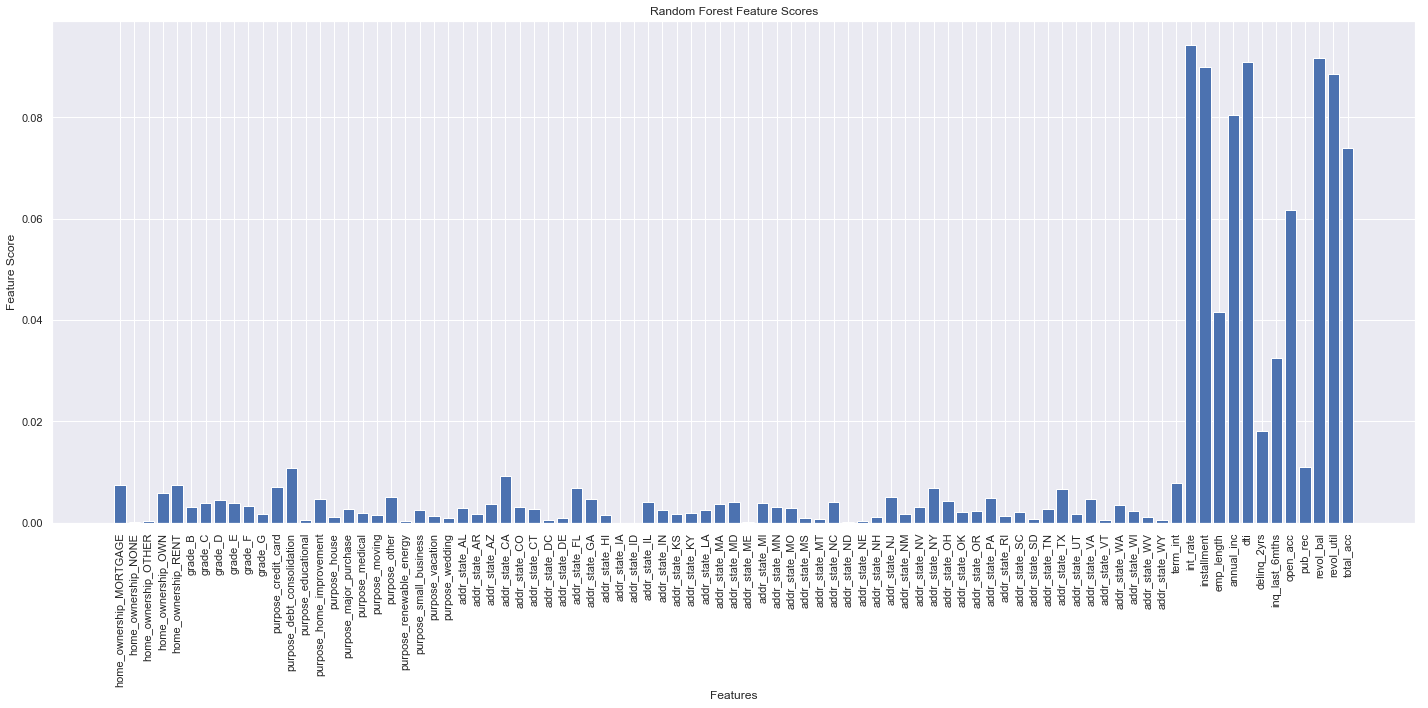

0.9091302485969934

In [7]:
# Fit model and view the most predictive features
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=2, random_state=0)
rf.fit(x,ytrain)
preds = rf.predict(xt)

#feature scores
feat_scores = rf.feature_importances_

# Plot the Random Forest scores
sns.set()
plt.rcParams["figure.figsize"] = (20,10)
plt.bar(range(len(features)), feat_scores)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.title('Random Forest Feature Scores')
plt.xlabel('Features')
plt.ylabel('Feature Score')
plt.tight_layout()
plt.savefig('full_feature_scores.png')
plt.show()

# model accuracy
accuracy_score(ytest, preds)

Next, we want to tune our model parameters to get the best results we can.

In [9]:
from sklearn.grid_search import GridSearchCV
rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [150,200,250,300]  
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='roc_auc', cv= 5)
CV_rfc.fit(xtrain, ytrain)
CV_rfc.best_params_

C:\Users\regru\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\regru\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


{'n_estimators': 300}

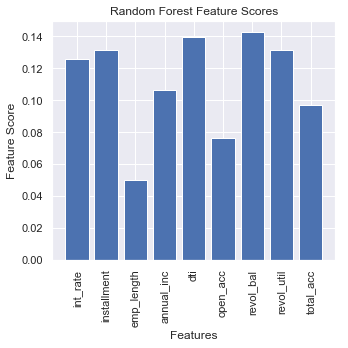

0.9126687552119723

In [10]:
# rename the training set that has only the most predictive features
top_feat = [75, 76, 77, 78, 79, 82, 84, 85, 86]
xtrain = x[:,top_feat]
xtest = xt[:,top_feat]
rf = RandomForestClassifier(n_jobs=2, n_estimators=300, random_state=0)
rf.fit(xtrain,ytrain)
rf_preds = rf.predict(xtest)

#feature scores
feat_scores = rf.feature_importances_

# Plot the Random Forest scores
sns.set()
plt.rcParams["figure.figsize"] = (5,5)
plt.bar(range(len(features[top_feat])), feat_scores)
plt.xticks(range(len(features[top_feat])), features[top_feat], rotation='vertical')
plt.title('Random Forest Feature Scores')
plt.xlabel('Features')
plt.ylabel('Feature Score')
plt.tight_layout()
plt.savefig('top_features_scores.png')
plt.show()

# model accuracy
accuracy_score(ytest, rf_preds)

We can look at the confusion matrix to further breakdown the prediction accuracy. Approximately, 8.5% of the predictions were incorrectly classified as non-default and almost 1% were incorrectly classified as default.

In [11]:
# confusion matrix for randomforest
pd.crosstab(ytest, rf_preds, rownames=['Actual'], colnames=['Predicted'], margins=True,normalize='all')

Predicted,0,1,All
Actual,,,
0,0.000699,0.087119,0.087818
1,0.000212,0.911970,0.912182
All,0.000911,0.999089,1.000000


In [12]:
# confusion matrix for randomforest (counts)
pd.crosstab(ytest, rf_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,155,19327,19482
1,47,202316,202363
All,202,221643,221845


Now for model comparison it's best to look at the Area Under the Curve of the ROC. The AUC for the Random Forest Classifier reached 0.6191.

In [13]:
# 5-fold cross validation using mean and stdev AUC value of ROC
def np_kfold_roc(clf, x, y,nfold=5):
    result = 0
    result_sq = 0
    for train, validation in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += roc_auc_score(y[validation], clf.predict_proba(x[validation])[:,1])# evaluate score function on held-out data
        result_sq += result**2
    return (result/nfold,np.sqrt(result/nfold))
np_kfold_roc(rf,xtrain,ytrain) #0.6981, 0.8355

(0.6980861090689071, 0.8355154750624952)

Next let's look at a plot of the lift curve. The plot below shows that if we used the top 10% highest probability predictions of loan default, we would improve our accuracy by approximately double.

C:\Users\regru\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


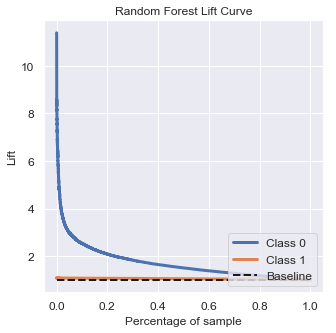

In [14]:
# Lift Graph
import scikitplot as skplt
skplt.metrics.plot_lift_curve(y_true=ytest, y_probas=rf.predict_proba(xtest))
sns.set()
#plt.rcParams["figure.figsize"] = (5,5)
plt.title('Random Forest Lift Curve')
plt.savefig('rf_lift_curve.png')
plt.show()

We will go through the same steps for three additional models to see if we can get any improvement in prediction accuracy.

In [15]:
#xgboost
from xgboost import XGBClassifier
# fit model to training data
xg_mod = XGBClassifier()
xg_mod.fit(xtrain, ytrain)
# make predictions for test data
xg_preds = xg_mod.predict(xtest)
# evaluate predictions
accuracy_score(ytest, xg_preds)

C:\Users\regru\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9122315129933062

In [16]:
# confusion matrix
pd.crosstab(ytest, xg_preds, rownames=['Actual'], colnames=['Predicted'], margins=True, normalize='all')

Predicted,0,1,All
Actual,,,
0,0.000059,0.087759,0.087818
1,0.000009,0.912173,0.912182
All,0.000068,0.999932,1.000000


In [17]:
# confusion matrix
pd.crosstab(ytest, xg_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,13,19469,19482
1,2,202361,202363
All,15,221830,221845


In [18]:
# 5-fold cross validation and AUC value of ROC
np_kfold_roc(xg_mod,xtrain,ytrain) #0.7046, 0.8394

(0.7045878229457945, 0.8393972974377476)

C:\Users\regru\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


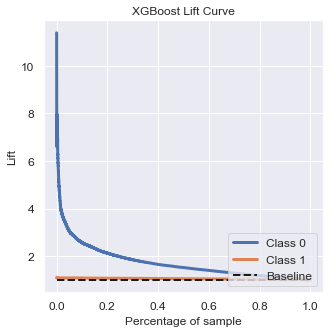

In [19]:
# Lift Graph
skplt.metrics.plot_lift_curve(y_true=ytest, y_probas=xg_mod.predict_proba(xtest))
sns.set()
plt.title('XGBoost Lift Curve')
plt.savefig('xgb_lift_curve.png')
plt.show()

In [20]:
#catboost
from catboost import CatBoostClassifier
catb_mod = CatBoostClassifier(silent=True)
#train the model
catb_mod.fit(xtrain,ytrain)
# make the prediction using the resulting model
catb_preds = catb_mod.predict(xtest)
#accuracy
accuracy_score(ytest, catb_preds)

0.9131691045549821

In [21]:
# confusion matrix
pd.crosstab(ytest, catb_preds, rownames=['Actual'], colnames=['Predicted'], margins=True, normalize='all')

Predicted,0.0,1.0,All
Actual,,,
0,0.001947,0.085871,0.087818
1,0.000960,0.911222,0.912182
All,0.002907,0.997093,1.000000


In [22]:
# confusion matrix
pd.crosstab(ytest, catb_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0.0,1.0,All
Actual,,,
0,432,19050,19482
1,213,202150,202363
All,645,221200,221845


In [23]:
# 5-fold cross validation using mean and stdev AUC value of ROC
np_kfold_roc(catb_mod,xtrain,ytrain) #0.7285, 0.8535

(0.7285394838620189, 0.8535452441798378)

C:\Users\regru\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


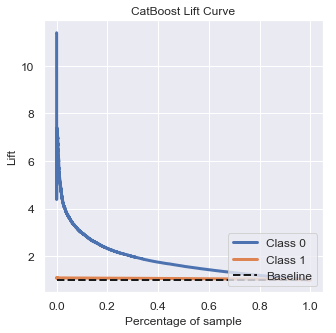

In [24]:
# Lift Graph
skplt.metrics.plot_lift_curve(y_true=ytest, y_probas=catb_mod.predict_proba(xtest))
sns.set()
plt.title('CatBoost Lift Curve')
plt.savefig('catb_lift_curve.png')
plt.show()

In [25]:
#logistic regression
from sklearn.linear_model import LogisticRegression
# fit model to training data
logreg = LogisticRegression()
logreg.fit(xtrain,ytrain)
#make predictions on test data
logreg_preds = logreg.predict(xtest)
#accuracy
accuracy_score(ytest, logreg_preds)

0.9121548829137461

In [26]:
# confusion matrix
pd.crosstab(ytest, logreg_preds, rownames=['Actual'], colnames=['Predicted'], margins=True, normalize='all')

Predicted,0,1,All
Actual,,,
0,0.000009,0.087809,0.087818
1,0.000036,0.912146,0.912182
All,0.000045,0.999955,1.000000


In [27]:
# confusion matrix
pd.crosstab(ytest, logreg_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,2,19480,19482
1,8,202355,202363
All,10,221835,221845


In [28]:
# 5-fold cross validation using mean and stdev AUC value of ROC
np_kfold_roc(logreg,xtrain,ytrain) #0.5209, 0.7217

(0.5209201779382543, 0.7217480016863602)

C:\Users\regru\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


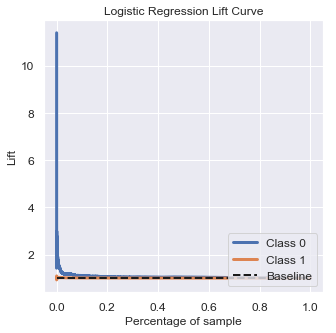

In [29]:
# Lift Graph
skplt.metrics.plot_lift_curve(y_true=ytest, y_probas=logreg.predict_proba(xtest))
sns.set()
plt.title('Logistic Regression Lift Curve')
plt.savefig('logreg_lift_curve.png')
plt.show()

In [30]:
# Calculate ROC curve for each model
from sklearn.metrics import roc_curve, auc
fpr1, tpr1, threshold1 = roc_curve(ytest, rf_preds)
fpr2, tpr2, threshold2 = roc_curve(ytest, xg_preds)
fpr3, tpr3, threshold3 = roc_curve(ytest, catb_preds)
fpr4, tpr4, threshold4 = roc_curve(ytest, logreg_preds)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)

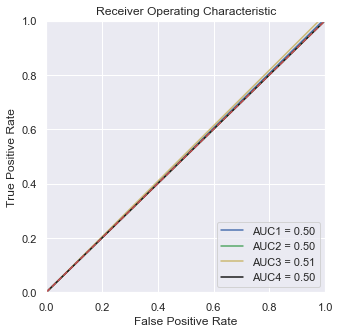

In [31]:
# Plot ROC curves
sns.set()
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'AUC1 = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC2 = %0.2f' % roc_auc2)
plt.plot(fpr3, tpr3, 'y', label = 'AUC3 = %0.2f' % roc_auc3)
plt.plot(fpr4, tpr4, 'k', label = 'AUC4 = %0.2f' % roc_auc4)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC Curves')
plt.show()

Finally, let's look at stacking multiple models together to see if we can get any improvement. I did not include the Logistic Regression model in the stack because of its poor AUC score.

In [32]:
from sklearn import model_selection
from mlxtend.classifier import StackingClassifier
clf1 = CatBoostClassifier(silent=True)
clf2 = RandomForestClassifier(n_jobs=2,n_estimators=300, random_state=0)
clf3 = LogisticRegression()
xgb = XGBClassifier()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=xgb)

sclf.fit(xtrain,ytrain)
stacked_preds = sclf.predict(xtest)
#accuracy
accuracy_score(ytest, stacked_preds)

C:\Users\regru\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9126687552119723

In [33]:
# confusion matrix for stackedmodels
pd.crosstab(ytest, stacked_preds, rownames=['Actual'], colnames=['Predicted'], margins=True, normalize='all')

Predicted,0,1,All
Actual,,,
0,0.000699,0.087119,0.087818
1,0.000212,0.911970,0.912182
All,0.000911,0.999089,1.000000


In [34]:
# 5-fold cross validation using mean and stdev AUC value of ROC
np_kfold_roc(sclf,xtrain,ytrain) 

(0.5031347643896412, 0.7093199309124488)

C:\Users\regru\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


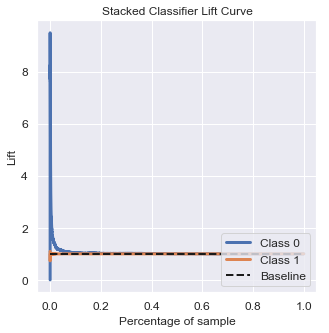

In [35]:
# Lift Graph
skplt.metrics.plot_lift_curve(y_true=ytest, y_probas=sclf.predict_proba(xtest))
plt.title('Stacked Classifier Lift Curve')
plt.show()